In [25]:
import numpy as np
import pandas as pd
import logging
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import umap
import umap.plot
import seaborn as sns
import scipy 


In [26]:
traindata = ad.read_h5ad("/home/rverplanke/Thesis/data/phase2-private-data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod2.h5ad")

traindata.shape

# Check if the matrix is sparse and count the zeros
if isinstance(traindata.X, (scipy.sparse.csr_matrix, scipy.sparse.csc_matrix)):
    # Get the total number of elements in the matrix
    total_elements = traindata.X.shape[0] * traindata.X.shape[1]
    
    # Get the number of non-zero elements
    non_zero_elements = traindata.X.count_nonzero()
    
    # Calculate the number of zeros
    zero_elements = total_elements - non_zero_elements
    
    print(f"Number of zeros in the sparse matrix: {zero_elements} and total: {total_elements}")
else:
    print("The matrix is not sparse.")

Number of zeros in the sparse matrix: 12692822 and total: 13431000


In [30]:
# results

lslout = ad.read_h5ad("outputLSL.h5ad")
linregout = ad.read_h5ad("outputlinreg.h5ad")
rick_m_mod2 = ad.read_h5ad("output_m_mod2.h5ad")
deng_m_mod2 = ad.read_h5ad("outputdeng.h5ad")
rick2_m_mod2 = ad.read_h5ad("rick2_m_mod2.h5ad")
linreg_m_mod2 = ad.read_h5ad("linreg_m_mod2.h5ad")
transformer_m_mod2 = ad.read_h5ad("transformer_m_mod2.h5ad")
transformer2_m_mod2 = ad.read_h5ad("transformer2_m_mod2.h5ad")
encoder_m_mod2 = ad.read_h5ad("encoder_m_mod2.h5ad")
batch_m_mod2 = ad.read_h5ad("mlpbatch_m_mod2.h5ad")

deng_c_mod2 = ad.read_h5ad("deng_c_mod2.h5ad")
rick_c_mod2 = ad.read_h5ad("output_c_mod2.h5ad")
rick2_c_mod2 = ad.read_h5ad("rick_c_mod2.h5ad")
test_c_mod2 = ad.read_h5ad("test_c_mod2.h5ad")
novel_c_mod2 = ad.read_h5ad("novel_c_mod2.h5ad")
linreg_c_mod2 = ad.read_h5ad("linreg_c_mod2.h5ad")
encoder_c_mod2 = ad.read_h5ad("encoder_c_mod2.h5ad")
batch_c_mod2 = ad.read_h5ad("mlpbatch_c_mod2.h5ad")

linreg_m_rna = ad.read_h5ad("linreg_m_rna.h5ad")
rick_m_rna = ad.read_h5ad("output_m_rna.h5ad")
rick2_m_rna = ad.read_h5ad("rick2_m_rna.h5ad")
lsl_m_rna = ad.read_h5ad("lsl_m_rna.h5ad")
deng_m_rna = ad.read_h5ad("deng_m_rna.h5ad")
encoder_m_rna = ad.read_h5ad("encoder_m_rna.h5ad")
batch_m_rna = ad.read_h5ad("mlpbatch_m_rna.h5ad")
novel_m_rna = ad.read_h5ad("novel_m_rna.h5ad")

linreg_c_rna = ad.read_h5ad("linreg_c_rna.h5ad")
rick_c_rna = ad.read_h5ad("output_c_rna.h5ad")
deng_c_rna = ad.read_h5ad("deng_c_rna.h5ad")
rick2_c_rna = ad.read_h5ad("rick2_c_rna.h5ad")
encoder_c_rna = ad.read_h5ad("encoder_c_rna.h5ad")
transformer_c_rna = ad.read_h5ad("transformer_c_rna.h5ad")
novel_c_rna = ad.read_h5ad("novel_c_rna.h5ad")
batch_c_rna = ad.read_h5ad("mlpbatch_c_rna.h5ad")

batchenc_m_mod2 = ad.read_h5ad("batchencoder_m_mod2.h5ad")
batchenc_m_rna = ad.read_h5ad("batchencoder_m_rna.h5ad")
batchenc_c_mod2 = ad.read_h5ad("batchencoder_c_mod2.h5ad")
batchenc_c_rna = ad.read_h5ad("batchencoder_c_rna.h5ad")
# NOTES 
# m_mod2 = ATAC -> RNA
# m_rna = RNA -> ATAC
# c_rna = RNA -> ADT
# c_mod2 = ADT -> RNA 
# test matrices 
true_m_mod2 =  ad.read_h5ad("/home/rverplanke/Thesis/data/phase2-private-data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod2.h5ad")
true_c_mod2 = ad.read_h5ad("/home/rverplanke/Thesis/data/phase2-private-data/predict_modality/openproblems_bmmc_cite_phase2_mod2/openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_mod2.h5ad")
true_m_rna = ad.read_h5ad("/home/rverplanke/Thesis/data/phase2-private-data/predict_modality/openproblems_bmmc_multiome_phase2_rna/openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod2.h5ad")
true_c_rna = ad.read_h5ad("/home/rverplanke/Thesis/data/phase2-private-data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad")

true_c_rna.obs['batch'].unique()


['s4d1', 's4d9', 's4d8']
Categories (12, object): ['s1d1', 's1d2', 's1d3', 's2d1', ..., 's3d7', 's4d1', 's4d8', 's4d9']

/tmp/ipykernel_656/3948295918.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(batch_m_mod2)


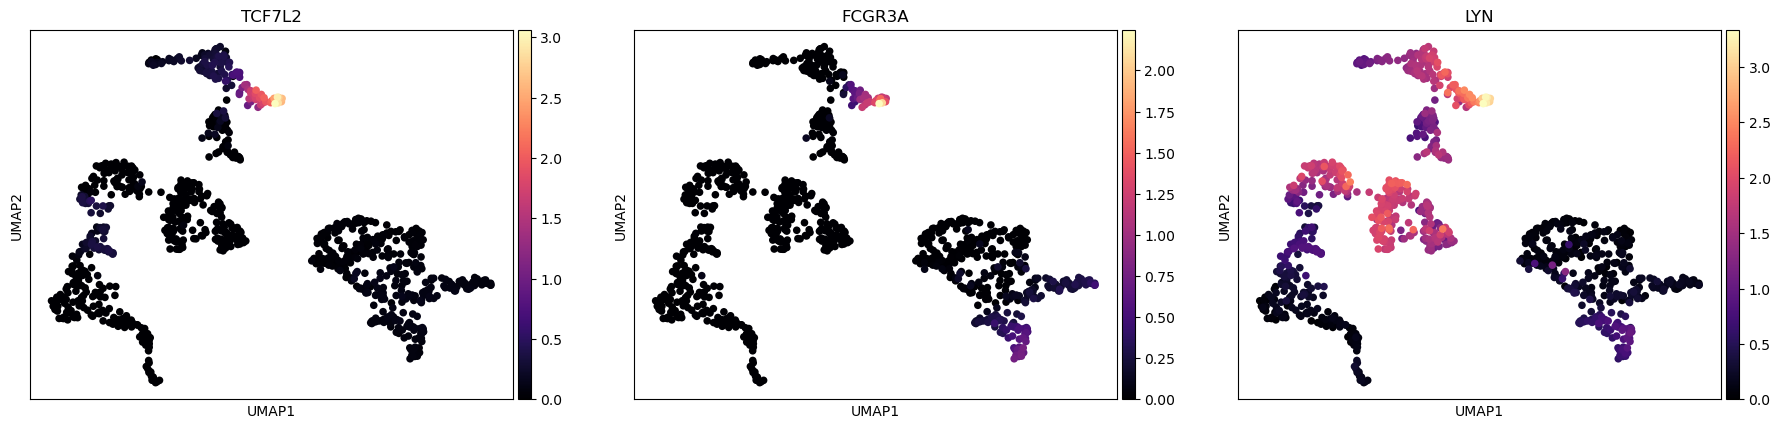

In [4]:

sc.pp.pca(batch_m_mod2, n_comps=50)
sc.pp.neighbors(batch_m_mod2, n_neighbors=20)
sc.tl.leiden(batch_m_mod2)
sc.tl.umap(batch_m_mod2)
sc.pl.umap(batch_m_mod2, color=['TCF7L2', 'FCGR3A', 'LYN'], color_map ='magma') #,'Rat-IgG1','Mouse-IgG2a


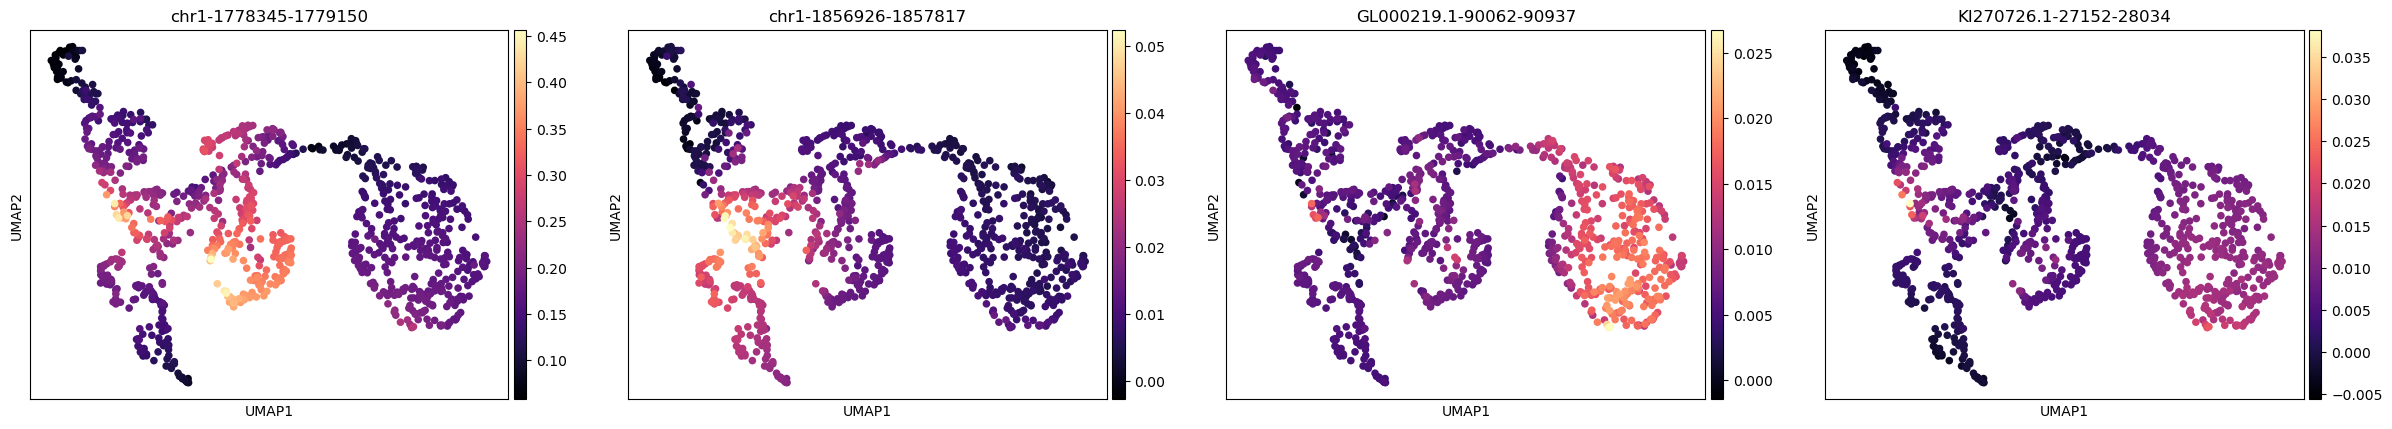

In [5]:
rick2_m_rna.var_names
sc.pp.pca(rick2_m_rna, n_comps=50)
sc.pp.neighbors(rick2_m_rna, n_neighbors=20)
sc.tl.leiden(rick2_m_rna)
sc.tl.umap(rick2_m_rna)
sc.pl.umap(rick2_m_rna, color=['chr1-1778345-1779150', 'chr1-1856926-1857817', 'GL000219.1-90062-90937', 'KI270726.1-27152-28034'], color_map ='magma') #,'Rat-IgG1','Mouse-IgG2a

In [6]:
marker_prots = {
    
    'CD14+ Mono': ['CD14', 'CD11b', 'CD62P'],
    'CD16+ Mono': ['CD11c', 'CD172a', 'CD88', 'CD85j'],
    'cDC2': ['CD11c',  'CD1c', 'FceRIa'],
    'pDCs': ['CD303', 'CD304'], 
    
    #Ery linage
    'Proerythroblast': ['CD105'],
    'Erythroblast': ['CD82', 'CD71'], # CD82 also in B
    'Normoblast/Reticulocyte': ['CD71'], 
    #'Reticulocyte': ['CD71'],  

    # B linage
    'Naive CD20+ B': ['IgD'],
    'B1 B': ['CD40', 'CD35', 'CD268', 'IgD'], # (IgD- !)
    'Transitional B': ['CD38', 'CD24'], # 'CD24', 'CD81', 'CD9'
    'Plasma cells': ['CD63', 'CD319'], 
    'Plasmablast': ['CD39', 'CD319'], # CD86

    # T linage
    'CD4+ T activated': ['CD4', 'CD45RO', 'CD25'], # CD25 negative, since these should be T regs
    'Treg':['CD25', 'CD39'],
    'CD4+ T naive': ['CD4', 'CD45RA'],
    
    'CD8+ T activated TIGIT+': ['CD8', 'CD45RO', 'TIGIT'],
    'CD8+ T activated CD69+': ['CD8', 'CD45RO', 'CD69'],
    'CD8+ T naive': ['CD8', 'CD45RA'],

    'gdT':['TCRVd2', 'CD161'],
    
    'NKT': ['TCRVa7.2'], #not 100% sure

    'NK': ['CD56', 'CD94', 'CD335'],  # 'CD57'?
    
    # Progenitors
    'ILC': ['CD127', 'CD103'], # CD103? also mentioned as Treg
    'MK/E prog':['CD112', 'CD105', 'CD352'],
    'HSC': ['CD13', 'CD155', 'CD112'],
    'Lymph prog':['CD112', 'CD81'], # close to HSC
    'G/M prog':['CD112', 'CD86']

}

In [7]:
marker_genes = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'], # TFRC negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],  # TFRC positive
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers   # CRACD as well, but not present in data
    'NK': ['GNLY', 'NKG7', 'CD247', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'], # GRIK4 as well, but not present in data
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],  # new: STMN1
    'naive CD20+ B - IGKC+':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'],
    'naive CD20+ B - IGKC-':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'], # IGKC negative
    'B1 B - IGKC+':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'],# Note IGHD and IGHM are negative markers
    'B1 B - IGKC-':['MS4A1', 'SSPN', 'ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM', 'IGKC'],# Note IGKC, IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cells': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker   # RF4 as well, but not present in data
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDCs': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'], 
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'], 
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'PLCB1'], # 'RYR3' as well,  but not present in data
    'HSPC STMN1+':['STMN1', 'HMGB1'] # newly characterized
}

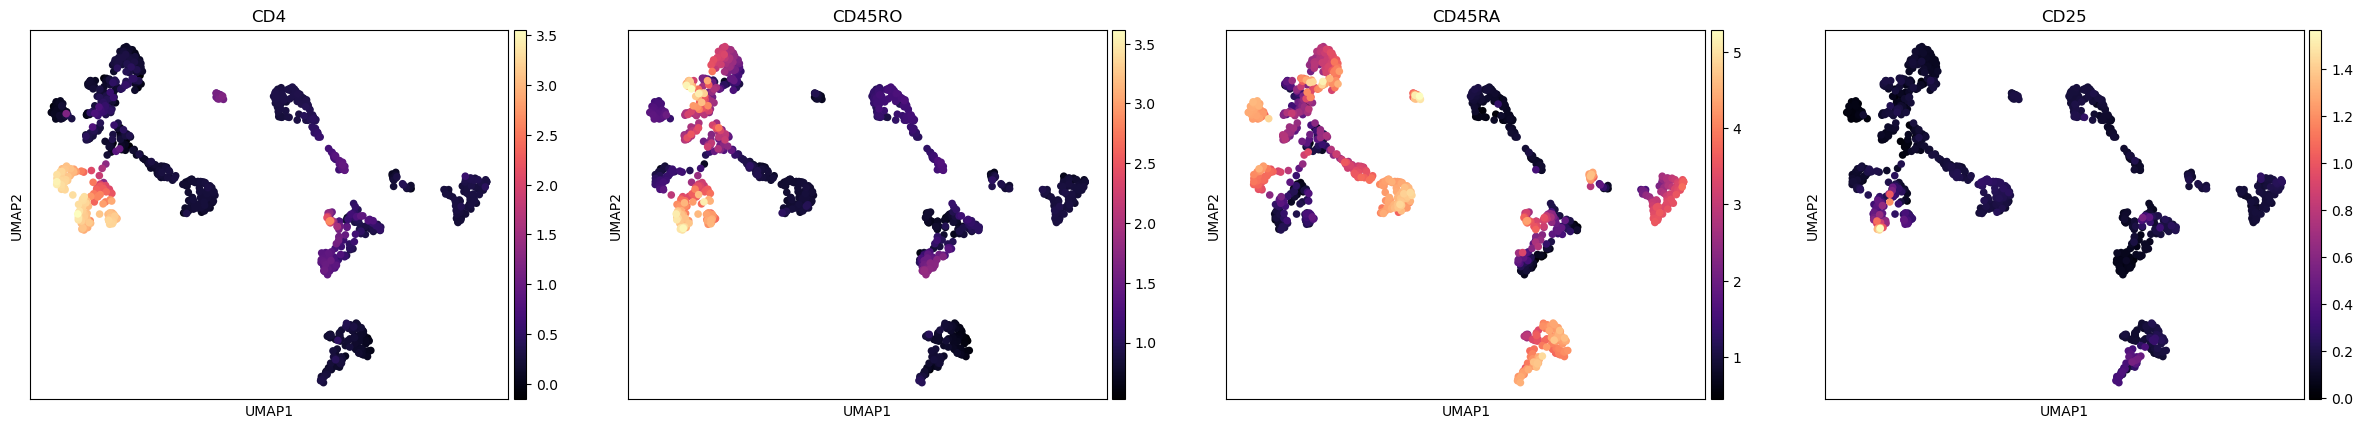

In [15]:
# CD4+ T activated
sc.pp.pca(rick2_c_rna, n_comps=50)
sc.pp.neighbors(rick2_c_rna, n_neighbors=20)
sc.tl.leiden(rick2_c_rna)
sc.tl.umap(rick2_c_rna)
sc.pl.umap(rick2_c_rna, color=['CD4', 'CD45RO', 'CD45RA', 'CD25'], color_map ='magma') #,'Rat-IgG1','Mouse-IgG2a

In [40]:

# Check unique batch labels in the dataset
unique_batches = true_c_rna.obs['batch'].unique()
print(f"Unique batches before cleanup: {unique_batches}")

# Optional: Remove unwanted batch labels if necessary
# This step depends on your specific dataset and requirements
# Example: remove cells with batch labels that are not in a predefined list
valid_batches = ['s4d1', 's4d8', 's4d9']  # example valid batches
true_c_rna = true_c_rna[true_c_rna.obs['batch'].isin(valid_batches), :]

# Verify unique batches after cleanup
unique_batches_after = true_c_rna.obs['batch'].unique()
print(f"Unique batches after cleanup: {unique_batches_after}")


Unique batches before cleanup: ['s4d1', 's4d9', 's4d8']
Categories (12, object): ['s1d1', 's1d2', 's1d3', 's2d1', ..., 's3d7', 's4d1', 's4d8', 's4d9']
Unique batches after cleanup: ['s4d1', 's4d9', 's4d8']
Categories (3, object): ['s4d1', 's4d8', 's4d9']


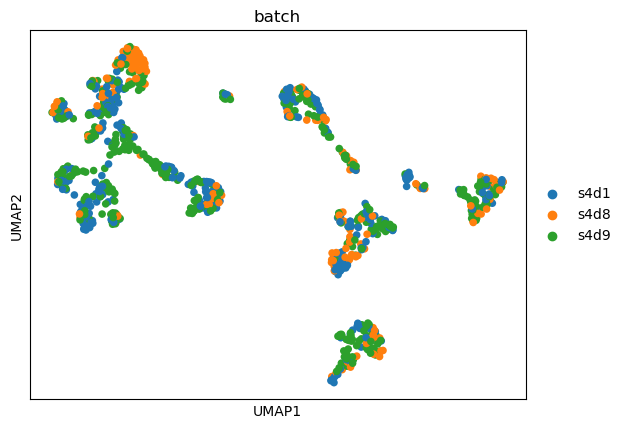

In [42]:
# CD4+ T activated
sc.pp.pca(rick2_c_rna, n_comps=50)
sc.pp.neighbors(rick2_c_rna, n_neighbors=20)
sc.tl.leiden(rick2_c_rna)
sc.tl.umap(rick2_c_rna)
sc.pl.umap(rick2_c_rna, color='batch')

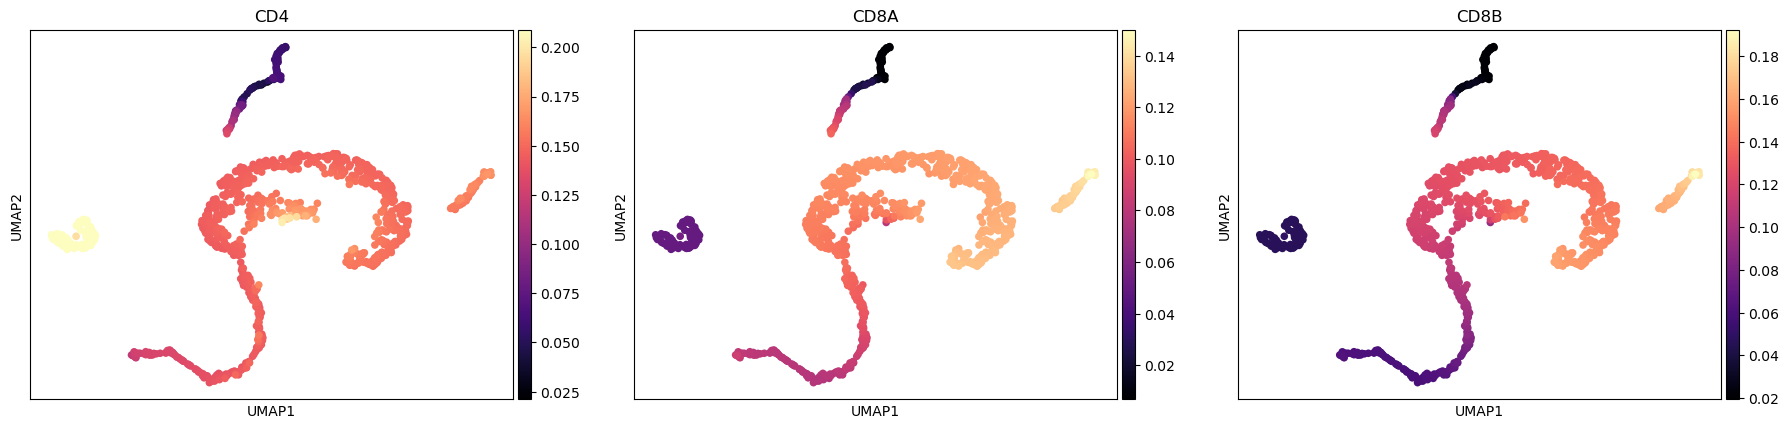

In [9]:

sc.pp.pca(rick2_c_mod2, n_comps=50)
sc.pp.neighbors(rick2_c_mod2, n_neighbors=20)
sc.tl.leiden(rick2_c_mod2)
sc.tl.umap(rick2_c_mod2)
sc.pl.umap(rick2_c_mod2, color=['CD4', 'CD8A', 'CD8B'], color_map ='magma') #,'Rat-IgG1','Mouse-IgG2a

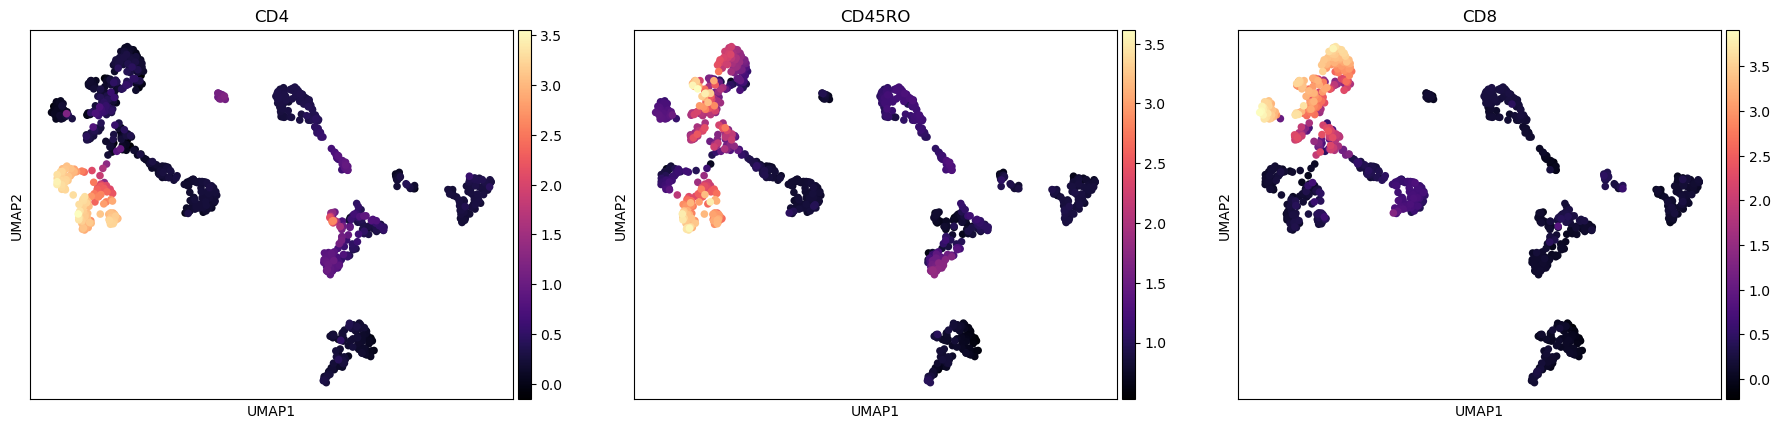

In [10]:
sc.pp.pca(rick2_c_rna, n_comps=50)
sc.pp.neighbors(rick2_c_rna, n_neighbors=20)
sc.tl.leiden(rick2_c_rna)
rick2_c_rna.write('rickpca_c_rna.h5ad')
sc.tl.umap(rick2_c_rna)
sc.pl.umap(rick2_c_rna, color=['CD4', 'CD45RO', 'CD8'], color_map ='magma') #,'Rat-IgG1','Mouse-IgG2a

In [11]:
sc.pp.pca(rick2_c_rna, n_comps=50)
sc.pp.neighbors(rick2_c_rna, n_neighbors=20)
sc.tl.leiden(rick2_c_rna)
sc.tl.umap(rick2_c_rna)
sc.tl.leiden(rick2_c_rna, resolution=0.3, key_added='leiden_res0.3')
sc.tl.leiden(rick2_c_rna, resolution=0.5, key_added='leiden_res0.5')
sc.tl.leiden(rick2_c_rna, resolution=0.8, key_added='leiden_res0.8')
sc.tl.leiden(rick2_c_rna, resolution=1, key_added='leiden_res1')

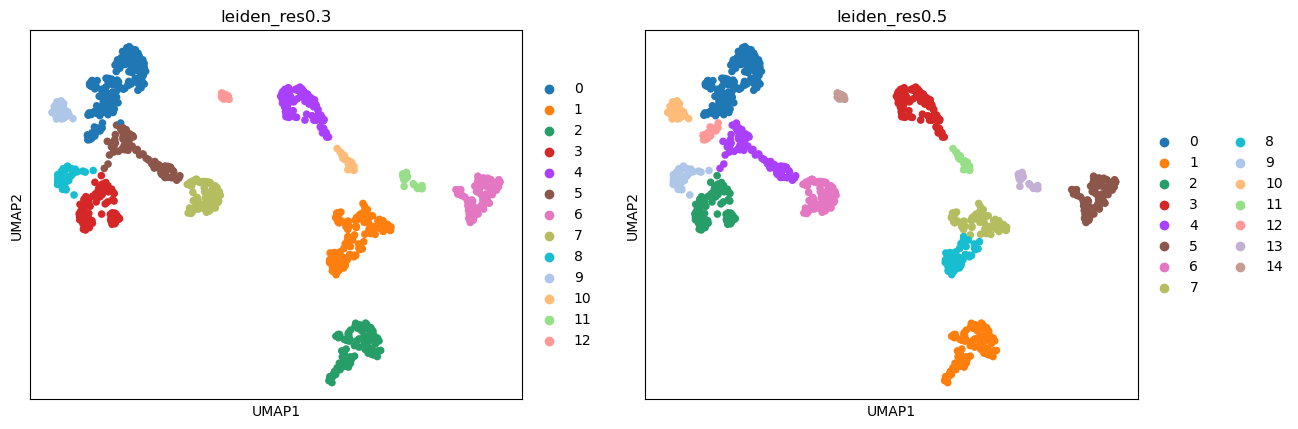

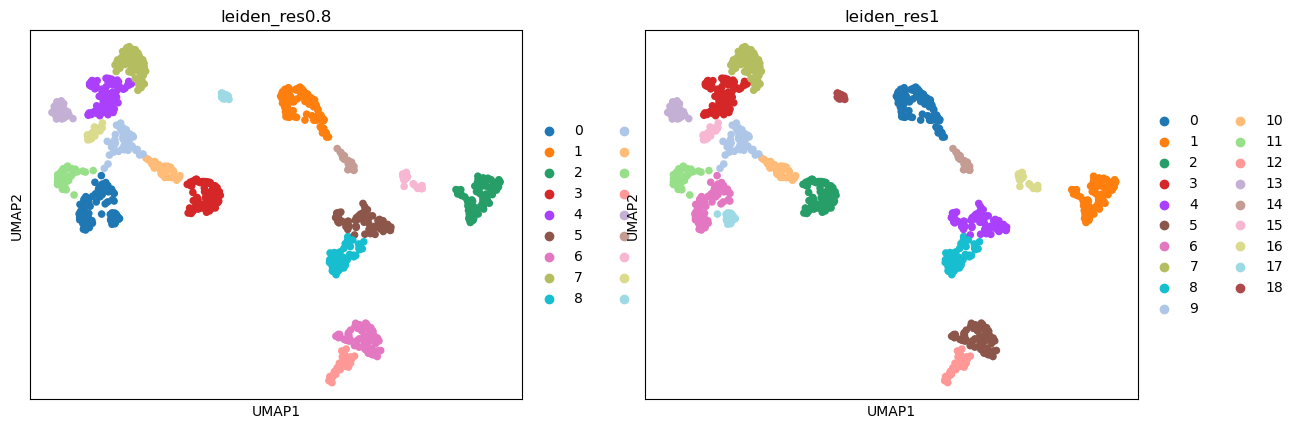

In [13]:
sc.pl.umap(rick2_c_rna, color=['leiden_res0.3', 'leiden_res0.5'])
sc.pl.umap(rick2_c_rna, color=['leiden_res0.8', 'leiden_res1'])

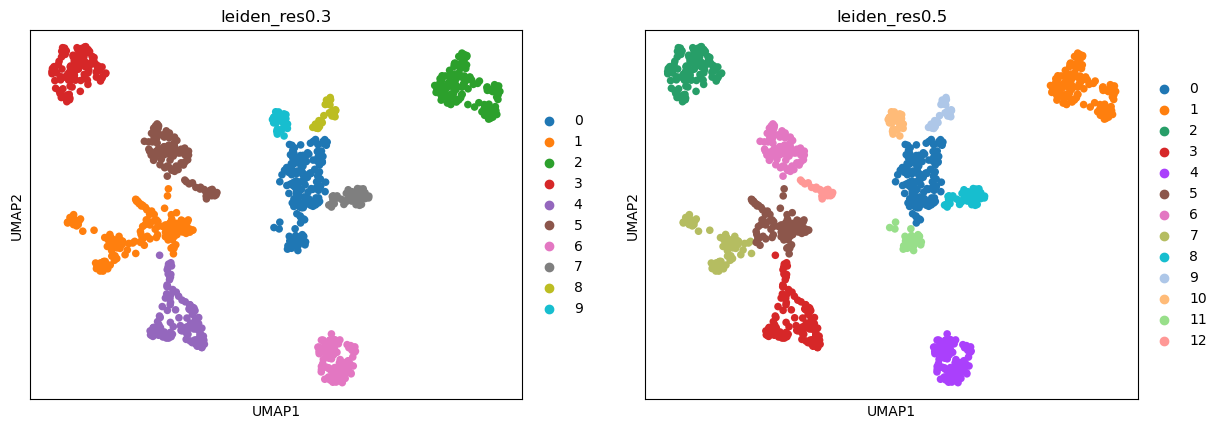

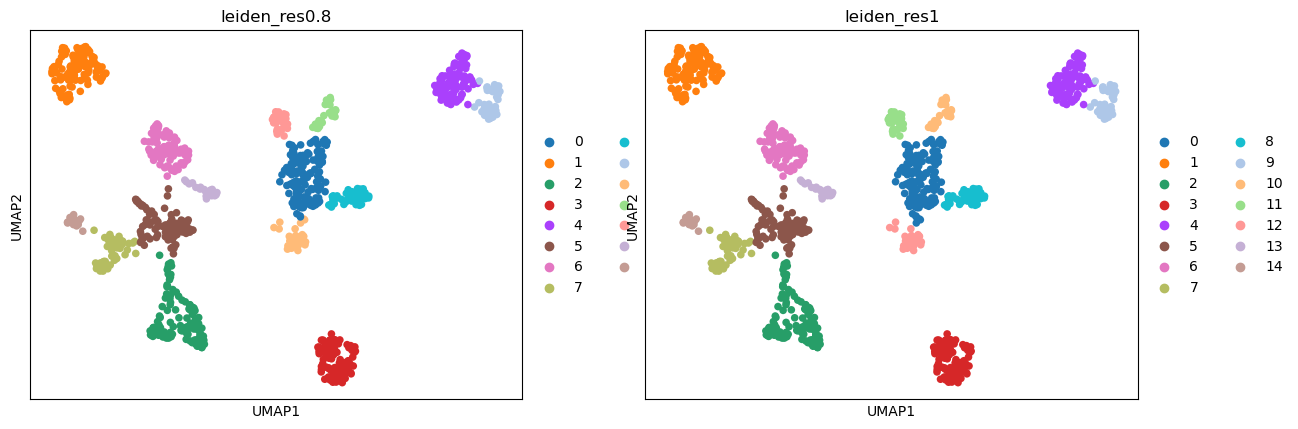

In [14]:
sc.pp.pca(true_c_rna, n_comps=50)
sc.pp.neighbors(true_c_rna, n_neighbors=20)
sc.tl.leiden(true_c_rna)
sc.tl.umap(true_c_rna)
sc.tl.leiden(true_c_rna, resolution=0.3, key_added='leiden_res0.3')
sc.tl.leiden(true_c_rna, resolution=0.5, key_added='leiden_res0.5')
sc.tl.leiden(true_c_rna, resolution=0.8, key_added='leiden_res0.8')
sc.tl.leiden(true_c_rna, resolution=1, key_added='leiden_res1')
sc.pl.umap(true_c_rna, color=['leiden_res0.3', 'leiden_res0.5'])
sc.pl.umap(true_c_rna, color=['leiden_res0.8', 'leiden_res1'])

<Axes: >

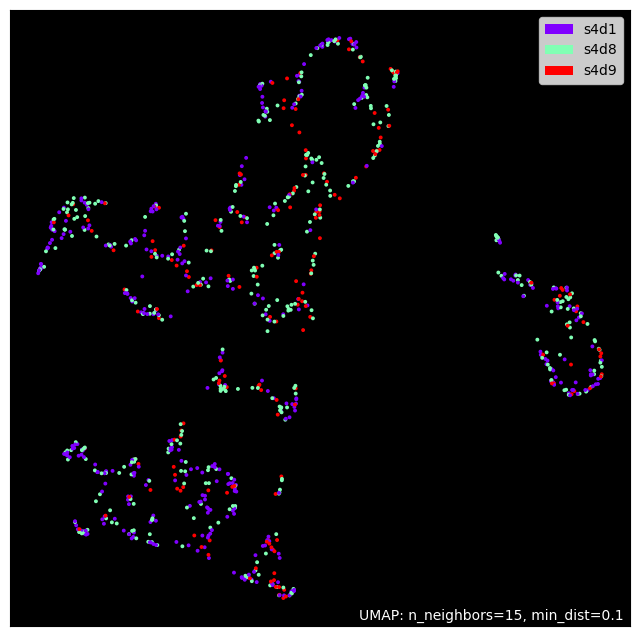

In [ ]:
embedder_mod1 = TruncatedSVD()
rick2_m_mod2pca = embedder_mod1.fit_transform(rick2_m_mod2.X)


mapper = umap.UMAP().fit(rick2_m_mod2pca)
umap.plot.points(mapper, labels=rick2_m_mod2.obs.batch, theme='fire')

In [47]:
# sns.heatmap(sc.tl.marker_gene_overlap(true_m_mod2, reference_markers=true_m_mod2.var_names, key='rank_genes_res0.5'), annot=True)
# plt.show()

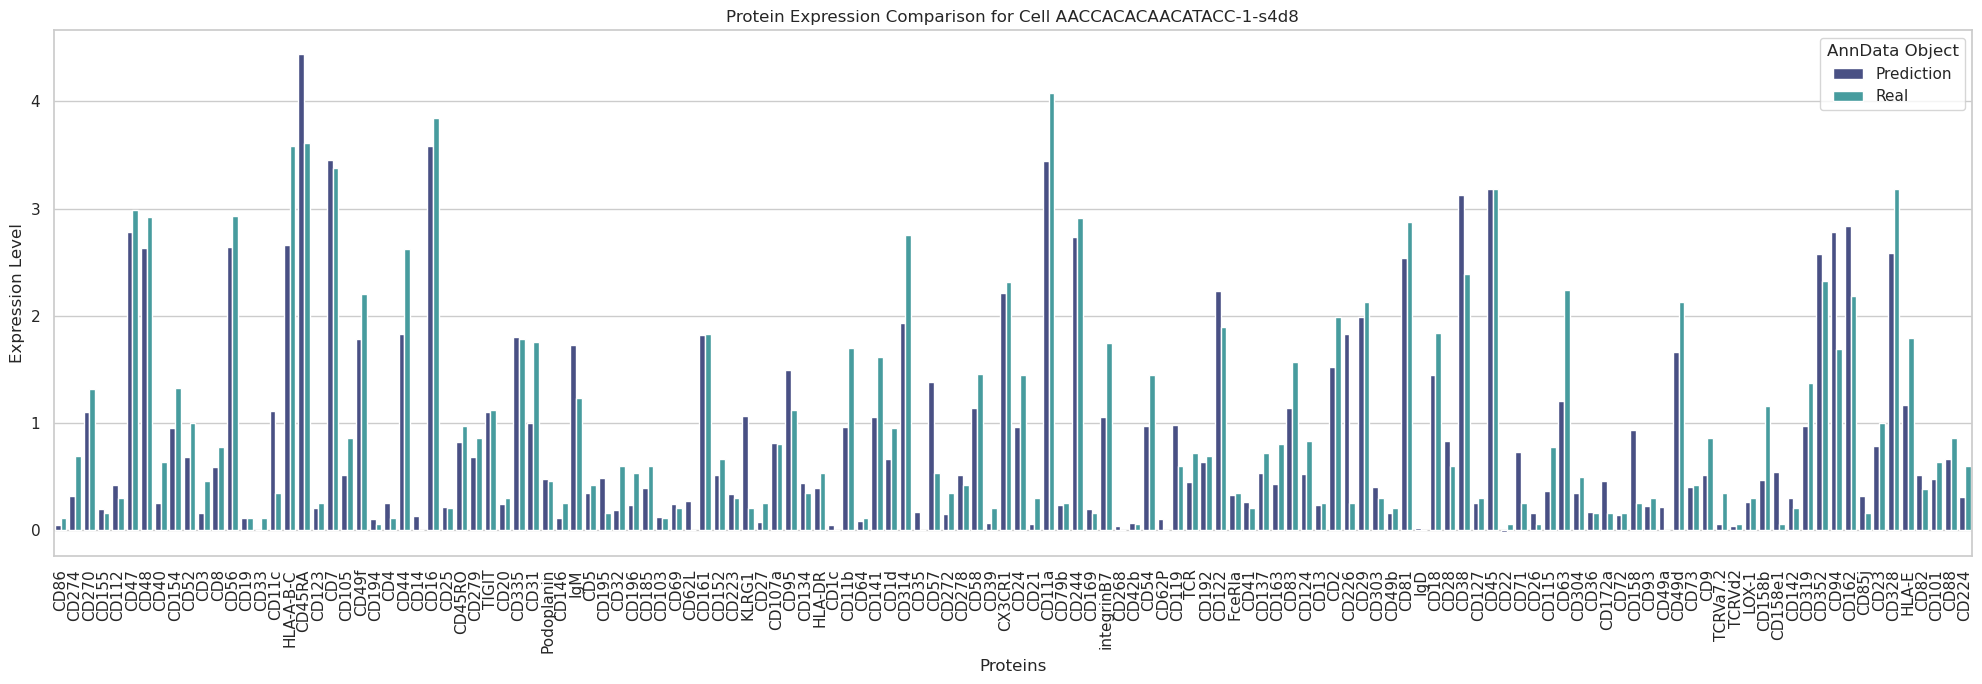

In [13]:
adata1 = rick2_c_rna
adata2 = true_c_rna

cell_id = 'AACCACACAACATACC-1-s4d8'

# Check if the cell exists in both AnnData objects
if cell_id in adata1.obs_names and cell_id in adata2.obs_names:
    # Extract the protein data for the cell from both AnnData objects
    protein_data1 = adata1[cell_id, :].X
    protein_data2 = adata2[cell_id, :].X
    
# If the data is sparse, convert it to dense
    if not isinstance(protein_data1, np.ndarray):
        protein_data1 = protein_data1.toarray().flatten()
    else:
        protein_data1 = protein_data1.flatten()

    if not isinstance(protein_data2, np.ndarray):
        protein_data2 = protein_data2.toarray().flatten()
    else:
        protein_data2 = protein_data2.flatten()
    
    # Create a DataFrame for easier comparison
    protein_comparison = pd.DataFrame({
        'Protein': adata1.var_names,
        'Prediction': protein_data1,
        'Real': protein_data2
    })
    
    # Melt the DataFrame for easier plotting
    protein_comparison_melted = pd.melt(protein_comparison, id_vars=['Protein'], var_name='AnnData', value_name='Expression')

    # Plot the comparison
    plt.figure(figsize=(20, 7))
    sns.set(style="whitegrid")
    ax = sns.barplot(x='Protein', y='Expression', hue='AnnData', palette='mako', data=protein_comparison_melted)
    ax.set_title(f'Protein Expression Comparison for Cell {cell_id}')
    ax.set_xlabel('Proteins')
    ax.set_ylabel('Expression Level')
    plt.xticks(rotation=90)
    plt.legend(title='AnnData Object')
    plt.tight_layout()
    plt.show()
else:
    print(f"The cell ID {cell_id} is not present in both AnnData objects.")

In [5]:
def calculate_rmse(true_test_mod2, pred_test_mod2):
    if pred_test_mod2.var["feature_types"][0] == "GEX":
        return  root_mean_squared_error(true_test_mod2.X.toarray(), pred_test_mod2.X.toarray())
    else:
        raise NotImplementedError("Only set up to calculate RMSE for GEX data")

In [6]:
def baseline_linear(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Baseline method training a linear regressor on the input data'''
    input_mod1 = ad.concat(
        {"train": input_train_mod1, "test": input_test_mod1},
        axis=0,
        join="outer",
        label="group",
        fill_value=0,
        index_unique="-", 
    )
    
    # Binarize ATAC 
    if input_train_mod1.var["feature_types"][0] == "ATAC":
        input_mod1.X[input_mod1.X > 1] = 1
    elif input_train_mod2.var["feature_types"][0] == "ATAC":
        input_train_mod2.X[input_mod1.X > 1] = 1
    
    # Do PCA on the input data
    logging.info('Performing dimensionality reduction on modality 1 values...')
    embedder_mod1 = TruncatedSVD(n_components=50)
    mod1_pca = embedder_mod1.fit_transform(input_mod1.X)
    
    logging.info('Performing dimensionality reduction on modality 2 values...')
    embedder_mod2 = TruncatedSVD(n_components=50)
    mod2_pca = embedder_mod2.fit_transform(input_train_mod2.layers["log_norm"])
    
    # split dimred mod 1 back up for training
    X_train = mod1_pca[input_mod1.obs['group'] == 'train']
    X_test = mod1_pca[input_mod1.obs['group'] == 'test']
    y_train = mod2_pca
    
    assert len(X_train) + len(X_test) == len(mod1_pca)
    
    logging.info('Running Linear regression...')
    
    reg = LinearRegression()
    
    # Train the model on the PCA reduced modality 1 and 2 data
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    # Project the predictions back to the modality 2 feature space
    y_pred = y_pred @ embedder_mod2.components_
    
    pred_test_mod2 = ad.AnnData(
        X = y_pred,
        obs = input_test_mod1.obs,
        var = input_train_mod2.var,
    
    )
    
    # Add the name of the method to the result
    pred_test_mod2.uns["method"] = "linear"
    
    return pred_test_mod2

In [7]:
def baseline_mean(input_train_mod1, input_train_mod2, input_test_mod1):
    '''Dummy method that predicts mean(input_train_mod2) for all cells'''
    logging.info('Calculate mean of the training data modality 2...')
    
    # Calculate the mean along the correct axis and ensure the result is a numpy array
    mean_mod2 = np.asarray(input_train_mod2.X.mean(axis=0)).flatten()
    
    # Repeat the mean value to match the shape of the test data
    y_pred = np.tile(mean_mod2, (input_test_mod1.shape[0], 1))
    
    # Prepare the output data object
    pred_test_mod2 = ad.AnnData(
        X=y_pred,
        obs=input_test_mod1.obs,
        var=input_train_mod2.var,
    )
    
    pred_test_mod2.uns["method"] = "mean"

    return pred_test_mod2


In [8]:
true_c_rna.obs

,batch,size_factors
CCTCTAGAGGGAGATA-1-s4d1,s4d1,0.877465
GTGGGAAAGCCGATTT-1-s4d9,s4d9,0.368332
CTGCATCGTCCAGCAC-1-s4d8,s4d8,0.340693
AGGTTACTCACCCTCA-1-s4d8,s4d8,0.675278
ATGGAGGCAGGTTCAT-1-s4d9,s4d9,0.471660
...,...,...
ATGGTTGTCGCCCAGA-1-s4d1,s4d1,0.514767
ATCCTATGTTGGGATG-1-s4d1,s4d1,0.234756
CTACCTGTCAAGCTGT-1-s4d1,s4d1,0.953712
AACCACACAACATACC-1-s4d8,s4d8,0.821679


In [29]:
print(f'\nmy 2nd method for multiome rna had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), rick2_m_rna.X.toarray()):.4f}')
print(f'linreg for multiome rna had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), linreg_m_rna.X.toarray()):.4f}')
print(f'encoder for multiome rna had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), encoder_m_rna.X.toarray()):.4f}')
print(f'deng for multiome rna had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), deng_m_rna.X.toarray()):.4f}')
print(f'batchmlp for multiome rna had a RMSE of 0.1548') # hard coded due to accidental file deletion
print(f'batchenc for multiome rna had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), batchenc_m_rna.X.toarray()):.4f}')
print(f'novel for multiome rna had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), novel_m_rna.X.toarray()):.4f}')
print(f'lsl (winner) for multiome rna had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), lsl_m_rna.X.toarray()):.4f}\n')

print(f'deng for multiome mod 2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), deng_m_mod2.X.toarray()):.4f}')
print(f'lsl for multiome mod 2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), lslout.X.toarray()):.4f}')
print(f'linreg for multiome mod 2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), linreg_m_mod2.X.toarray()):.4f}')
print(f'my 2nd method for multiome mod2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), rick2_m_mod2.X.toarray()):.4f}')
print(f'encoder for multiome mod2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), encoder_m_mod2.X.toarray()):.4f}')
print(f'batchmlp for multiome mod2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), batch_m_mod2.X.toarray()):.4f}')
print(f'transformer for multiome mod2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), transformer_m_mod2.X.toarray()):.4f}')
#print(f'batchenc for multiome mod2 had a RMSE of {root_mean_squared_error(true_m_rna.X.toarray(), batchenc_m_mod2.X.toarray()):.4f}')
print(f'2nd transformer for multiome mod2 had a RMSE of {root_mean_squared_error(true_m_mod2.X.toarray(), transformer2_m_mod2.X.toarray()):.4f}\n')

print(f'linreg for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), linreg_c_rna.X.toarray()):.4f}')
print(f'my method for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), rick_c_rna.X.toarray()):.4f}')
print(f'my 2nd method for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), rick2_c_rna.X.toarray()):.4f}')
print(f'encoderlstm for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), encoder_c_rna.X.toarray()):.4f}')
print(f'transformer for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), transformer_c_rna.X.toarray()):.4f}')
print(f'batchmlp for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), batch_c_rna.X.toarray()):.4f}')
print(f'novel for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), novel_c_rna.X.toarray()):.4f}')
print(f'batchenc for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), batchenc_c_rna.X.toarray()):.4f}')
print(f'deng (winner) for cite rna had a RMSE of {root_mean_squared_error(true_c_rna.X.toarray(), deng_c_rna.X.toarray()):.4f}\n')

print(f'my method for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), rick_c_mod2.X.toarray()):.4f}')
print(f'my 2nd method for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), rick2_c_mod2.X.toarray()):.4f}')
print(f'linreg for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), linreg_c_mod2.X.toarray()):.4f}')
print(f'deng for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), deng_c_mod2.X.toarray()):.4f}')
print(f'encoderlstm for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), encoder_c_mod2.X.toarray()):.4f}')
print(f'batchmlp for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), batch_c_mod2.X.toarray()):.4f}')
print(f'batchenc for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), batchenc_c_mod2.X.toarray()):.4f}')
print(f'novel (winner) for cite mod2 had a RMSE of {root_mean_squared_error(true_c_mod2.X.toarray(), novel_c_mod2.X.toarray()):.4f}\n')



my 2nd method for multiome rna had a RMSE of 0.1516
linreg for multiome rna had a RMSE of 0.1520
encoder for multiome rna had a RMSE of 0.1531
deng for multiome rna had a RMSE of 0.1543
batchmlp for multiome rna had a RMSE of 0.1548
batchenc for multiome rna had a RMSE of 0.1550
lsl (winner) for multiome rna had a RMSE of 0.1513

deng for multiome mod 2 had a RMSE of 0.1925
lsl for multiome mod 2 had a RMSE of 0.1892
linreg for multiome mod 2 had a RMSE of 0.1964
my 2nd method for multiome mod2 had a RMSE of 0.1926
encoder for multiome mod2 had a RMSE of 0.1951
batchmlp for multiome mod2 had a RMSE of 0.1913
transformer for multiome mod2 had a RMSE of 0.1894
2nd transformer for multiome mod2 had a RMSE of 0.1896

linreg for cite rna had a RMSE of 0.6334
my method for cite rna had a RMSE of 0.4345
my 2nd method for cite rna had a RMSE of 0.4196
encoderlstm for cite rna had a RMSE of 0.4216
transformer for cite rna had a RMSE of 0.5711
batchmlp for cite rna had a RMSE of 0.4330
novel fo

In [5]:
from scipy.stats import pearsonr

# Assuming true_m_rna, rick2_m_rna, linreg_m_rna, encoder_m_rna, deng_m_rna, lsl_m_rna, etc.
# are all sparse matrices or have a .X.toarray() method to get numpy arrays.

# Define a function to calculate Pearson's R
def calculate_pearson_r(true, predicted):
    true_values = true.X.toarray().flatten()
    predicted_values = predicted.X.toarray().flatten()
    return pearsonr(true_values, predicted_values)[0]

print(f'\nmy 2nd method for multiome rna had a Pearson R of {calculate_pearson_r(true_m_rna, rick2_m_rna):.4f}')
print(f'linreg for multiome rna had a Pearson R of {calculate_pearson_r(true_m_rna, linreg_m_rna):.4f}')
print(f'encoder for multiome rna had a Pearson R of {calculate_pearson_r(true_m_rna, encoder_m_rna):.4f}')
print(f'deng for multiome rna had a Pearson R of {calculate_pearson_r(true_m_rna, deng_m_rna):.4f}')
# Since batchmlp for multiome rna has a fixed RMSE value, we cannot calculate Pearson R without true and predicted values

print(f'lsl (winner) for multiome rna had a Pearson R of {calculate_pearson_r(true_m_rna, lsl_m_rna):.4f}\n')

print(f'deng for multiome mod 2 had a Pearson R of {calculate_pearson_r(true_m_mod2, deng_m_mod2):.4f}')
print(f'lsl for multiome mod 2 had a Pearson R of {calculate_pearson_r(true_m_mod2, lslout):.4f}')
print(f'linreg for multiome mod 2 had a Pearson R of {calculate_pearson_r(true_m_mod2, linreg_m_mod2):.4f}')
print(f'my 2nd method for multiome mod2 had a Pearson R of {calculate_pearson_r(true_m_mod2, rick2_m_mod2):.4f}')
print(f'encoder for multiome mod2 had a Pearson R of {calculate_pearson_r(true_m_mod2, encoder_m_mod2):.4f}')
print(f'batchmlp for multiome mod2 had a Pearson R of {calculate_pearson_r(true_m_mod2, batch_m_mod2):.4f}')
print(f'transformer for multiome mod2 had a Pearson R of {calculate_pearson_r(true_m_mod2, transformer_m_mod2):.4f}')
print(f'2nd transformer for multiome mod2 had a Pearson R of {calculate_pearson_r(true_m_mod2, transformer2_m_mod2):.4f}\n')

print(f'my method for cite mod2 had a Pearson R of {calculate_pearson_r(true_c_mod2, rick_c_mod2):.4f}')
print(f'my 2nd method for cite mod2 had a Pearson R of {calculate_pearson_r(true_c_mod2, rick2_c_mod2):.4f}')
print(f'linreg for cite mod2 had a Pearson R of {calculate_pearson_r(true_c_mod2, linreg_c_mod2):.4f}')
print(f'deng for cite mod2 had a Pearson R of {calculate_pearson_r(true_c_mod2, deng_c_mod2):.4f}')
print(f'encoderlstm for cite mod2 had a Pearson R of {calculate_pearson_r(true_c_mod2, encoder_c_mod2):.4f}')
print(f'batchmlp for cite mod2 had a Pearson R of {calculate_pearson_r(true_c_mod2, batch_c_mod2):.4f}')
print(f'novel (winner) for cite mod2 had a Pearson R of {calculate_pearson_r(true_c_mod2, novel_c_mod2):.4f}\n')

print(f'linreg for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, linreg_c_rna):.4f}')
print(f'my method for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, rick_c_rna):.4f}')
print(f'my 2nd method for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, rick2_c_rna):.4f}')
print(f'encoderlstm for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, encoder_c_rna):.4f}')
print(f'transformer for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, transformer_c_rna):.4f}')
print(f'batchmlp for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, batch_c_rna):.4f}')
print(f'novel for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, novel_c_rna):.4f}')
print(f'deng (winner) for cite rna had a Pearson R of {calculate_pearson_r(true_c_rna, deng_c_rna):.4f}')



my 2nd method for multiome rna had a Pearson R of 0.3304
linreg for multiome rna had a Pearson R of 0.3287
encoder for multiome rna had a Pearson R of 0.3004
deng for multiome rna had a Pearson R of 0.3254
lsl (winner) for multiome rna had a Pearson R of 0.3349

deng for multiome mod 2 had a Pearson R of 0.4229
lsl for multiome mod 2 had a Pearson R of 0.4189
linreg for multiome mod 2 had a Pearson R of 0.4010
my 2nd method for multiome mod2 had a Pearson R of 0.4127
encoder for multiome mod2 had a Pearson R of 0.4152
batchmlp for multiome mod2 had a Pearson R of 0.4062
transformer for multiome mod2 had a Pearson R of 0.3527
2nd transformer for multiome mod2 had a Pearson R of 0.3530

my method for cite mod2 had a Pearson R of 0.7373
my 2nd method for cite mod2 had a Pearson R of 0.7174
linreg for cite mod2 had a Pearson R of 0.7349
deng for cite mod2 had a Pearson R of 0.7532
encoderlstm for cite mod2 had a Pearson R of 0.7370
batchmlp for cite mod2 had a Pearson R of 0.7268
novel (w